In [1]:
%matplotlib inline
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
from tqdm import tqdm

In [2]:
# Plotting all in a single graph

# MCTS
mypath = 'MCTS_RESULTS/2022_NEW_C'
mcts_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
dates = [file.split("_")[2] for file in mcts_files]

# Baseline
bl_path = 'MCTS_RESULTS/10_2022_BL'
baselines = [f for f in listdir(bl_path) if isfile(join(bl_path, f))]
baselines = [b for b in baselines if b.split("_")[3] in dates]

# MCTS NOREALLOC
mypath_NR = 'MCTS_RESULTS/2022_NEW_C_NOREALLOC'
mcts_NR_files = [f for f in listdir(mypath_NR) if isfile(join(mypath_NR, f))]
dates = [file.split("_")[2] for file in mcts_NR_files]

# Baseline NOREALLOC
bl_path_NR = 'MCTS_RESULTS/10_2022_BL_NR'
baselines_NR = [f for f in listdir(bl_path_NR) if isfile(join(bl_path_NR, f))]
baselines_NR = [b for b in baselines_NR if b.split("_")[3] in dates]
print(len(mcts_files), len(baselines), len(mcts_NR_files), len(baselines_NR))

31 31 30 30


In [3]:
def logs_to_df(mypath, onlyfiles, baselines=False, norealloc=False):
    log_file_arr = {}

    for file in tqdm(onlyfiles):
        if baselines:
            date = file.split("_")[3]
        else:
            date = file.split("_")[2]
            
        bus_metrics = []
        stop_metrics = []
        
        start_bus_metrics = False
        start_stop_metrics = False
        
        log_path = f"{mypath}/{file}"
        with open(log_path) as file:
            for line in file:
                data = line.rstrip()
                in_brackets = re.findall("\[(.*?)\]", data)
                out_brackets = re.findall(r"(.*?)(?:\[.*?\]|$)", data)[1].strip()
                
                if 'bus_id,dwell_time,agg_delay,service_time,total_served,service_kms,current_stop,status' in line:
                    bus_metrics.append(out_brackets)
                    start_stop_metrics = False
                    start_bus_metrics = True
                    continue
                
                if 'stop_id,total_passenger_ons,total_passenger_offs,total_passenger_walk_away,total_served,service_kms,current_stop,status' in line:
                    stop_metrics.append(out_brackets)
                    start_stop_metrics = True
                    start_bus_metrics = False
                    continue

                if 'Count of all passengers' in line:
                    break
                
                if start_bus_metrics:
                    bus_metrics.append(out_brackets)
                
                if start_stop_metrics:
                    stop_metrics.append(out_brackets)
                    
        # break

        bus_df = pd.DataFrame([sub.split(",") for sub in bus_metrics])
        if bus_df.empty:
            continue
        # display(bus_df.head(1))
        new_header = bus_df.iloc[0] #grab the first row for the header
        bus_df = bus_df[1:] #take the data less the header row
        bus_df.columns = new_header #set the header row as the df header

        bus_df[new_header[:-2]] = bus_df[new_header[:-2]].apply(pd.to_numeric, errors='coerce')
        
        stop_df = pd.DataFrame([sub.split(",") for sub in stop_metrics])
        # display(stop_df.head(1))
        new_header = stop_df.iloc[0] #grab the first row for the header
        stop_df = stop_df[1:] #take the data less the header row
        stop_df.columns = new_header #set the header row as the df header

        stop_df[new_header[1:]] = stop_df[new_header[1:]].apply(pd.to_numeric, errors='coerce')
        stop_df = stop_df[['stop_id', 'total_passenger_ons', 'total_passenger_offs', 'total_passenger_walk_away']]
        # stop_df
        label = 'MCTS'
        if baselines:
            label = 'Greedy'
        nr_label = 'With Reallocation'
        if norealloc:
            nr_label = 'No Reallocation'
        log_file_arr[(date, label, nr_label)] = [bus_df, stop_df]
    return log_file_arr

In [4]:
mcts_logs_arr = logs_to_df(mypath, mcts_files)
mcts_NR_logs_arr = logs_to_df(mypath_NR, mcts_NR_files, norealloc=True)

bl_logs_arr = logs_to_df(bl_path, baselines, baselines=True)
bl_NR_logs_arr = logs_to_df(bl_path_NR, baselines_NR, baselines=True, norealloc=True)

all_files = mcts_logs_arr | mcts_NR_logs_arr | bl_logs_arr | bl_NR_logs_arr

100%|██████████| 30/30 [00:43<00:00,  1.46s/it]


In [5]:
df = []
for (date, baseline, norealloc), data  in all_files.items():
    # print(date, baseline, norealloc)
    tdf = data[0]
    total_served = tdf.total_served.sum()
    overflow_kms = tdf[tdf['bus_id'].isin(list(range(41, 46)))].service_kms.sum()
    df.append({"date":date, "Strategy": baseline, "Reallocation": norealloc,
                "total_served":total_served,
                "overflow_kms":overflow_kms})
df = pd.DataFrame(df)
df['date'] = pd.to_datetime(df['date'])
df['dow'] = df['date'].dt.day_of_week
df['day'] = df['date'].dt.day_name()

In [23]:
df.query("Strategy == 'MCTS' and Reallocation == 'With Reallocation'").mean()

/tmp/ipykernel_101141/2997931753.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df.query("Strategy == 'MCTS' and Reallocation == 'With Reallocation'").mean()
/tmp/ipykernel_101141/2997931753.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.query("Strategy == 'MCTS' and Reallocation == 'With Reallocation'").mean()


total_served    117639.483871
overflow_kms      1351.254839
dow                  3.064516
dtype: float64

In [24]:
117639.483871 - 114883.966667

2755.5172040000034

In [22]:
df.query("Strategy == 'MCTS' and Reallocation == 'No Reallocation'").mean()

/tmp/ipykernel_101141/1257717645.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df.query("Strategy == 'MCTS' and Reallocation == 'No Reallocation'").mean()
/tmp/ipykernel_101141/1257717645.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.query("Strategy == 'MCTS' and Reallocation == 'No Reallocation'").mean()


total_served    114883.966667
overflow_kms      1377.649667
dow                  3.166667
dtype: float64

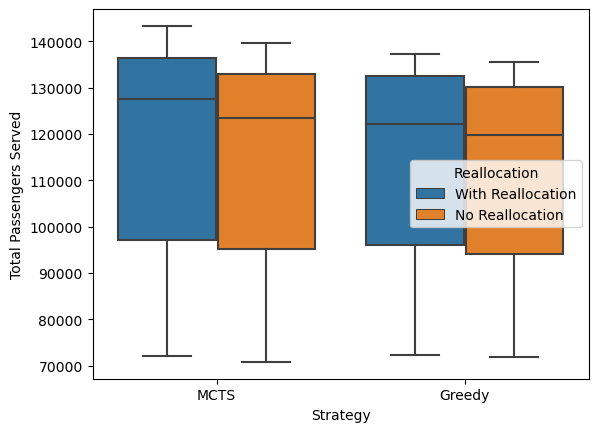

In [97]:
import matplotlib.pyplot as plt

df1 = df[['Strategy', 'Reallocation', 'total_served']].melt(id_vars = [
    'Strategy',
    'Reallocation'
])
import seaborn as sns
sns.boxplot(data = df1, x = 'Strategy', y = 'value', hue = 'Reallocation', showfliers=True)
# plt.legend(title='Reallocation')
# plt.xlabel('Strategy')
plt.ylabel('Total Passengers Served')
fp = 'plots/2022_served.png'
plt.savefig(fp, dpi=200, bbox_inches='tight')

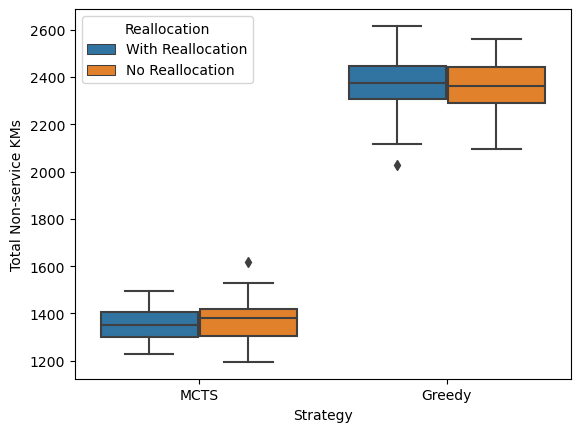

In [98]:
import matplotlib.pyplot as plt
df1 = df[['Strategy', 'Reallocation', 'overflow_kms']].melt(id_vars = [
    'Strategy',
    'Reallocation'
])
import seaborn as sns
sns.boxplot(data = df1, x = 'Strategy', y = 'value', hue = 'Reallocation', showfliers=True)
# plt.legend(title='Reallocation')
# plt.xlabel('Strategy')
plt.ylabel('Total Non-service KMs')

fp = 'plots/2022_deadkms.png'
plt.savefig(fp, dpi=200, bbox_inches='tight')

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Monday'),
  Text(1, 0, 'Sunday'),
  Text(2, 0, 'Tuesday'),
  Text(3, 0, 'Saturday'),
  Text(4, 0, 'Thursday'),
  Text(5, 0, 'Wednesday'),
  Text(6, 0, 'Friday')])

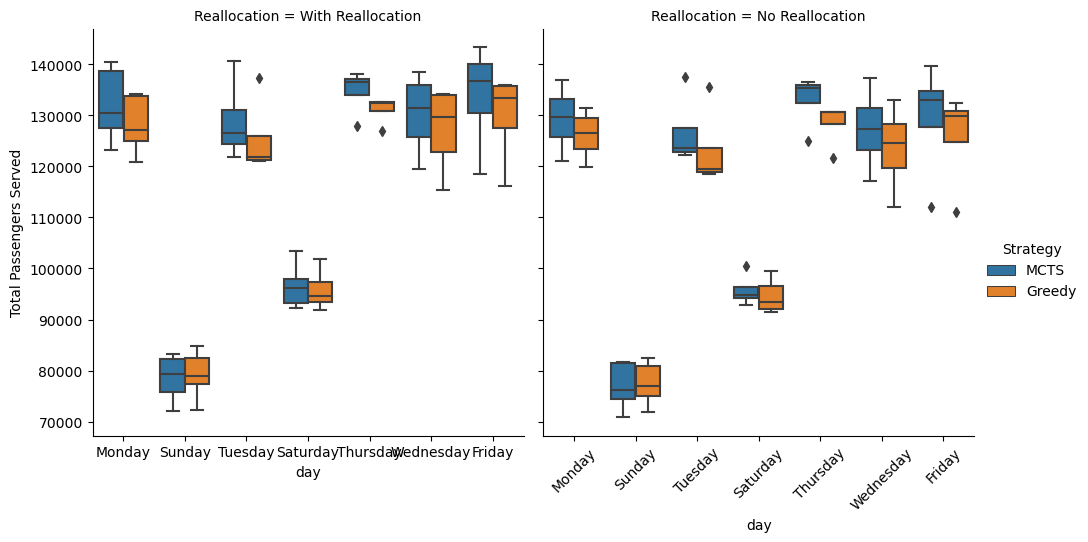

In [103]:
df1 = df[['Strategy', 'Reallocation', 'dow', 'total_served']].melt(id_vars = [
    'Strategy',
    'Reallocation',
    'day'
])
df1 = df1.rename({'value': 'Total Passengers Served'}, axis=1)
import seaborn as sns
# sns.boxplot(data = df1, x = 'dow', y = 'value', hue = 'baseline', showfliers=True)
sns.catplot(data=df1, x='dow', y='Total Passengers Served', col='Reallocation', hue = 'Strategy', kind='box', col_wrap=2)

fp = 'plots/2022_dow_served.png'
plt.savefig(fp, dpi=200, bbox_inches='tight')


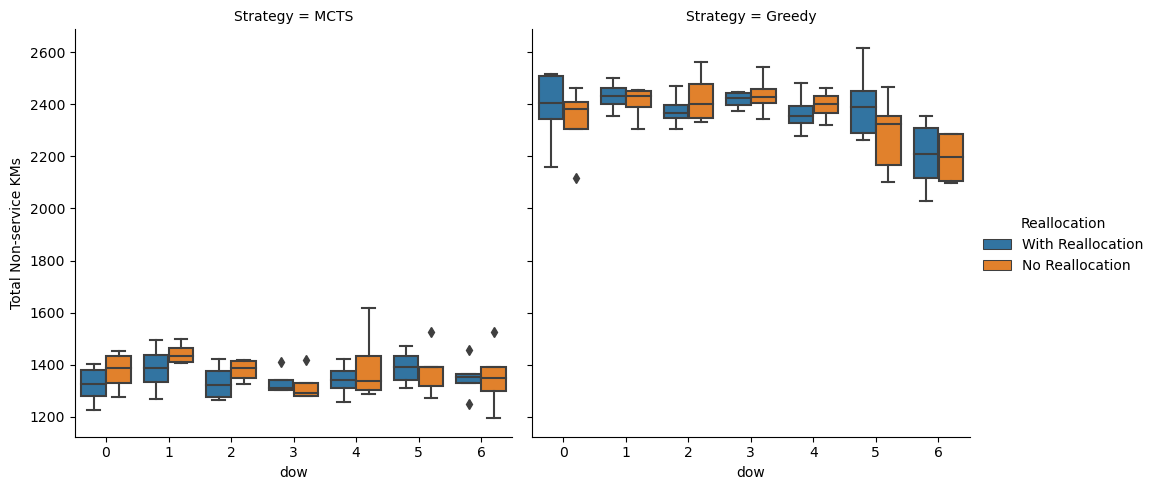

In [100]:
df1 = df[['Strategy', 'Reallocation', 'dow', 'overflow_kms']].melt(id_vars = [
    'Strategy',
    'Reallocation',
    'dow'
])
df1 = df1.rename({'value': 'Total Non-service KMs'}, axis=1)
import seaborn as sns
# sns.catplot(data=df1, x='dow', y='Total Non-service KMs', col='Reallocation', hue = 'Strategy', kind='box', col_wrap=2)
sns.catplot(data=df1, x='dow', y='Total Non-service KMs', col='Strategy', hue = 'Reallocation', kind='box', col_wrap=2)

fp = 'plots/2022_dow_deadkms.png'
plt.savefig(fp, dpi=200, bbox_inches='tight')

In [44]:
import glob
import re
import utils
import dateparser
import importlib
from tqdm import tqdm
importlib.reload(utils)

df_arr = []

listfiles = glob.glob('MCTS_RESULTS/2022_NEW_C/*.log')
for lf in tqdm(listfiles):
    date = re.findall(r'(202210\d{2})', lf)[0]
    date = dateparser.parse(date, date_formats=['%Y%m%d'], settings={'TIMEZONE': 'GMT-5'})
    df = utils.get_bus_dispatch_df(lf)
    df['date'] = date
    df['realloc'] = True
    df_arr.append(df)
    
listfiles = glob.glob('MCTS_RESULTS/2022_NEW_C_NOREALLOC/*.log')
for lf in tqdm(listfiles):
    date = re.findall(r'(202210\d{2})', lf)[0]
    date = dateparser.parse(date, date_formats=['%Y%m%d'], settings={'TIMEZONE': 'GMT-5'})
    df = utils.get_bus_dispatch_df(lf)
    df['date'] = date
    df['realloc'] = False
    df_arr.append(df)

df = pd.concat(df_arr)

100%|██████████| 30/30 [00:06<00:00,  4.29it/s]


With realloc    5792
No realloc      5686
diff             106
dtype: int64
With realloc    2461
No realloc      2519
diff             -58
dtype: int64


,With realloc,No realloc,diff
date,,,
2022-10-01,273,270,3
2022-10-02,246,231,15
2022-10-03,277,289,-12
2022-10-04,283,299,-16
2022-10-05,290,285,5
2022-10-06,285,285,0
2022-10-07,280,273,7
2022-10-08,270,269,1
2022-10-09,250,255,-5


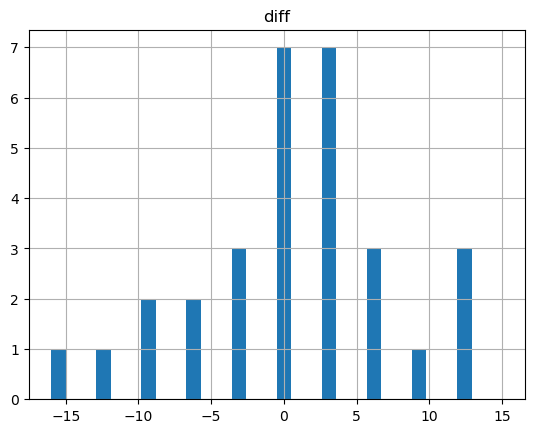

In [69]:
tdf = df.query("realloc == True and action == 'dispatch'")
tdf = tdf.groupby('date').count()
tdf = tdf[['realloc']].rename({'realloc':'With realloc'}, axis=1)

ttdf = df.query("realloc == False and action == 'dispatch'")
ttdf = ttdf.groupby('date').count()
ttdf = ttdf[['realloc']].rename({'realloc':'No realloc'}, axis=1)

tdf = pd.merge(tdf, ttdf, how='inner', left_index=True, right_index=True)
tdf['diff'] = tdf['With realloc'] - tdf['No realloc']
print(tdf.query("diff >= 0").sum())
print(tdf.query("diff < 0").sum())
tdf.hist('diff', width=1)
tdf